In [585]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [586]:
df = pd.read_csv("/content/RoomBasePrice_2024_06_11.csv")

Drop NaN based on ac because usually if a one-hot feature like ac, balcony, if one is Nan the rest is also Nan together.

In [587]:
data = df.dropna(subset=['ac'])
data = data.dropna(subset=['bedroom'])
data = data.dropna(subset=['room_id'])
data = data.dropna(subset=['lat'])

In [588]:
data.rename(columns={'name':'unit_type_name'}, inplace=True)

In [589]:
def impute_with_mode(df, features):
    """
    Impute missing values in the specified features of a DataFrame with the most common (mode) values.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features (list): List of column names to be imputed.

    Returns:
    pd.DataFrame: The DataFrame with imputed values.
    """
    for feature in features:
        if feature in df.columns:
            mode_value = df[feature].mode()[0]  # Get the mode value of the feature
            df[feature].fillna(mode_value, inplace=True)  # Impute missing values with the mode
        else:
            print(f"Warning: Column '{feature}' does not exist in the DataFrame.")
    return df

In [590]:
featuresToImpute = ['beds','capacity','bathroom', 'ac', 'balcony', 'beachfront', 'breakfast','building_staff', 'cable_tv', 'essentials', 'garden', 'gym', 'hair_dryer', 'hanger', 'heating', 'hot_water', 'kitchen', 'linens', 'lock', 'luggage_drop_off','parking', 'pool','private_entrance', 'shampoo', 'tv', 'washer', 'wifi', 'workspace']
data = impute_with_mode(data, featuresToImpute)

In [591]:
mean_value = data['distance_to_coastline'].mean()  # Get the mode value of the feature
data['distance_to_coastline'].fillna(mean_value, inplace=True)

In [592]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142 entries, 1 to 309
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   room_id                   142 non-null    float64
 1   average_baseline_price    142 non-null    float64
 2   number_of_bookings        142 non-null    int64  
 3   unit_id                   142 non-null    object 
 4   bathroom                  142 non-null    float64
 5   bedroom                   142 non-null    float64
 6   beds                      142 non-null    float64
 7   capacity                  142 non-null    float64
 8   unit_type_id              142 non-null    float64
 9   property_id               142 non-null    object 
 10  unit_type_name            142 non-null    object 
 11  ac                        142 non-null    float64
 12  balcony                   142 non-null    float64
 13  beachfront                142 non-null    float64
 14  breakfast      

In [593]:
#For FE and training prep
column_to_drop = ['unit_id', 'unit_type_id', 'property_id']
clean_data = data.drop(columns=column_to_drop)

In [594]:
dataProperOrder = ['room_id',
                        'unit_type_name',
                        'property_design',
                        'property_type',
                        'area_id',
                        'number_of_bookings',
                        'bedroom',
                        'bathroom',
                        'beds',
                        'capacity',
                        'ac',
                    'balcony', 'beachfront', 'breakfast','building_staff', 'cable_tv', 'essentials', 'garden', 'gym', 'hair_dryer', 'hanger', 'heating', 'hot_water', 'kitchen', 'linens', 'lock', 'luggage_drop_off','parking', 'pool','private_entrance', 'shampoo', 'tv', 'washer', 'wifi', 'workspace',
                   'lat', 'lng', 'distance_to_coastline','area_distance_to_airport', 'property_bedrooms', 'average_baseline_price']


In [595]:
clean_data = clean_data[dataProperOrder]

In [596]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142 entries, 1 to 309
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   room_id                   142 non-null    float64
 1   unit_type_name            142 non-null    object 
 2   property_design           142 non-null    float64
 3   property_type             142 non-null    float64
 4   area_id                   142 non-null    object 
 5   number_of_bookings        142 non-null    int64  
 6   bedroom                   142 non-null    float64
 7   bathroom                  142 non-null    float64
 8   beds                      142 non-null    float64
 9   capacity                  142 non-null    float64
 10  ac                        142 non-null    float64
 11  balcony                   142 non-null    float64
 12  beachfront                142 non-null    float64
 13  breakfast                 142 non-null    float64
 14  building_staff 

In [597]:
filepath = 'CLEAN_RoomBasePrice_11_06_2024.csv'
clean_data.to_csv(filepath)

In [598]:
clean_data.describe()

,room_id,property_design,property_type,number_of_bookings,bedroom,bathroom,beds,capacity,ac,balcony,...,shampoo,tv,washer,wifi,workspace,lat,lng,distance_to_coastline,property_bedrooms,average_baseline_price
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,...,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,1.420000e+02
mean,402840.626761,1.514085,3.598592,116.521127,1.316901,1.401408,1.323944,2.598592,0.978873,0.521127,...,0.718310,0.535211,0.084507,0.985915,0.880282,-8.654587,114.781158,2259.288484,7.345070,1.035582e+06
std,17173.842897,1.528620,0.825651,136.862188,0.836827,1.065646,0.838348,1.525480,0.144316,0.501322,...,0.451415,0.500524,0.279131,0.118257,0.325781,0.287746,1.414937,3532.922615,5.860126,1.006191e+06
min,378260.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-8.837896,110.360967,12.924400,1.000000,2.537926e+05
25%,394914.250000,0.000000,4.000000,20.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,-8.813940,115.110537,458.638250,4.000000,4.387704e+05
50%,397695.500000,1.000000,4.000000,67.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,-8.709399,115.130054,1133.150000,6.000000,7.743049e+05
75%,399751.500000,3.000000,4.000000,158.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,-8.655257,115.206654,2259.288484,7.000000,1.220445e+06
max,472846.000000,5.000000,4.000000,674.000000,5.000000,5.000000,5.000000,9.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-7.728722,115.586846,14402.100000,27.000000,6.651338e+06


convert area distance to airport data types.

In [599]:
def convert_time_to_minutes(time_str):
    if isinstance(time_str, str):
        if 'minute' in time_str:
            return float(time_str.split()[0])
        elif 'hour' in time_str:
            return float(time_str.split()[0]) * 60
        else:
            raise ValueError(f"Unknown time format: {time_str}")
    elif isinstance(time_str, float) and np.isnan(time_str):
        return np.nan
    else:
        raise TypeError(f"Expected string or NaN, got {type(time_str)}")

In [600]:
column = ["area_distance_to_airport"]
for c in column:
  clean_data[c] =  clean_data[c].apply(convert_time_to_minutes).astype('float64')

Handle missing values on area_distance_to_airport using same area_id using KNN Imputer.

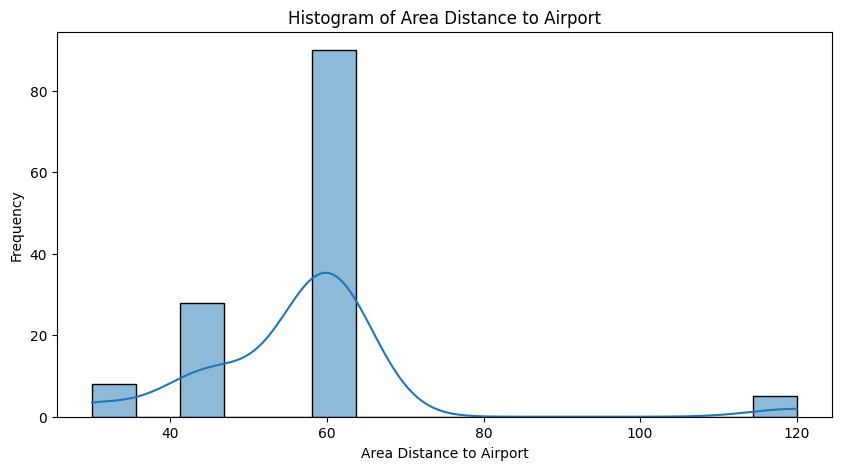

In [601]:
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(clean_data['area_distance_to_airport'], kde=True)
plt.xlabel('Area Distance to Airport')
plt.ylabel('Frequency')
plt.title('Histogram of Area Distance to Airport')
plt.show()

In [602]:
imputer = KNNImputer(n_neighbors=5)
clean_data[['area_distance_to_airport']] = imputer.fit_transform(clean_data[['area_distance_to_airport']])

In [603]:
clean_data.isna().sum()

room_id                     0
unit_type_name              0
property_design             0
property_type               0
area_id                     0
number_of_bookings          0
bedroom                     0
bathroom                    0
beds                        0
capacity                    0
ac                          0
balcony                     0
beachfront                  0
breakfast                   0
building_staff              0
cable_tv                    0
essentials                  0
garden                      0
gym                         0
hair_dryer                  0
hanger                      0
heating                     0
hot_water                   0
kitchen                     0
linens                      0
lock                        0
luggage_drop_off            0
parking                     0
pool                        0
private_entrance            0
shampoo                     0
tv                          0
washer                      0
wifi      

Features Engineering Process

In [604]:
clean_data['total_fas'] = df[['ac', 'balcony', 'beachfront', 'breakfast', 'building_staff',
                             'cable_tv', 'essentials', 'garden', 'gym', 'hair_dryer',
                             'hanger', 'heating', 'hot_water', 'kitchen', 'linens',
                             'lock', 'luggage_drop_off', 'parking', 'pool',
                             'private_entrance', 'shampoo', 'tv', 'washer', 'wifi',
                             'workspace']].sum(axis=1)
clean_data['ratio_bedroom_bathroom'] = clean_data['bedroom'] / clean_data['bathroom']
clean_data['ratio_bedroom_cap'] = clean_data['capacity'] / clean_data['bedroom']
clean_data['avg_price_distance_to_coast'] = clean_data['average_baseline_price'] / clean_data['distance_to_coastline']
clean_data['avg_price_distance_to_airport'] = clean_data['average_baseline_price'] / clean_data['area_distance_to_airport']
clean_data['avg_price_bedroom'] = clean_data['average_baseline_price'] / clean_data['bedroom']
clean_data['avg_price_beds'] = clean_data['average_baseline_price'] / clean_data['beds']
clean_data['avg_price_bathroom'] = clean_data['average_baseline_price'] / clean_data['bathroom']
clean_data['avg_price_total_fas'] = clean_data['average_baseline_price'] / clean_data['total_fas']

Training Process

In [605]:
numerical_cols = clean_data.select_dtypes(include=['float64', 'int64']).columns
z_scores = stats.zscore(clean_data[numerical_cols])
threshold = 5
outlier_mask = (abs(z_scores) > threshold).any(axis=1)
clean_data = clean_data[~outlier_mask]

In [606]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 1 to 309
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   room_id                        131 non-null    float64
 1   unit_type_name                 131 non-null    object 
 2   property_design                131 non-null    float64
 3   property_type                  131 non-null    float64
 4   area_id                        131 non-null    object 
 5   number_of_bookings             131 non-null    int64  
 6   bedroom                        131 non-null    float64
 7   bathroom                       131 non-null    float64
 8   beds                           131 non-null    float64
 9   capacity                       131 non-null    float64
 10  ac                             131 non-null    float64
 11  balcony                        131 non-null    float64
 12  beachfront                     131 non-null    float64


Using One Hot Encoding and Standard Scaler

In [607]:
clean_data.drop(columns=['room_id'], inplace=True)

<ipython-input-607-3c9bb83cd39b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data.drop(columns=['room_id'], inplace=True)


In [608]:
average_baseline_price = clean_data['average_baseline_price']
clean_data = clean_data.drop(columns=['average_baseline_price'])

categorical_cols = ['unit_type_name', 'area_id']
numerical_cols = clean_data.select_dtypes(include=['float64', 'int64']).columns

onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_encoded = onehot_encoder.fit_transform(clean_data[categorical_cols])

categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=onehot_encoder.get_feature_names_out(categorical_cols))

scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(clean_data[numerical_cols])

numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical_cols)

df_final = pd.concat([numerical_scaled_df, categorical_encoded_df, average_baseline_price.reset_index(drop=True)], axis=1)

df_final.head()


,property_design,property_type,number_of_bookings,bedroom,bathroom,beds,capacity,ac,balcony,beachfront,...,area_id_A0008,area_id_A0010,area_id_A0011,area_id_A0012,area_id_A0013,area_id_A0020,area_id_A0038,area_id_A0043,area_id_A0047,average_baseline_price
0,-0.994127,0.458717,-0.455280,-0.364502,-0.371274,-0.373002,-0.365095,0.0,0.947919,-0.373002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,375783.277454
1,-0.994127,0.458717,-0.209718,-0.364502,-0.371274,-0.373002,-0.365095,0.0,0.947919,-0.373002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,342269.690977
2,-0.994127,0.458717,-0.492486,-0.364502,-0.371274,-0.373002,0.328056,0.0,0.947919,-0.373002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,404418.747155
3,-0.994127,0.458717,-0.492486,-0.364502,-0.371274,-0.373002,0.328056,0.0,0.947919,-0.373002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,404418.747155
4,-0.994127,0.458717,-0.432956,-0.364502,-0.371274,-0.373002,0.328056,0.0,0.947919,-0.373002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,383891.636199


Separate features and target

In [609]:
X = df_final.drop(columns=['average_baseline_price'])
y = df_final['average_baseline_price']

Divide data for training and testing.

In [610]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define some models that we used.

In [611]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Machine": SVR(),
    "XGB Regressor":XGBRegressor()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = mae
    print(f"{name} MAE: {mae:.2f}")


Linear Regression MAE: 182724679285668896.00
Decision Tree MAE: 62325.09
Random Forest MAE: 37136.09
Gradient Boosting MAE: 40391.85
Support Vector Machine MAE: 364579.61
XGB Regressor MAE: 77941.15


In [612]:
best_model_name = min(results, key=results.get)
best_mae = results[best_model_name]
print(f"Best model: {best_model_name} with MAE: {best_mae:.2f}")

Best model: Random Forest with MAE: 37136.09
